In [21]:
# IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import glob, os, shutil,random
import tensorflow as tf
import cv2

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [22]:
# IMPORTS
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense, BatchNormalization, Input, Lambda, Activation, Conv2D, MaxPooling2D, Reshape, Bidirectional, TimeDistributed, GRU
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [23]:
# DIRECTORIES
DIRECTORY = '../input/mendeley-and-sdnet/Mixed_Dataset/'
TRAIN_DIR = os.path.join(DIRECTORY, 'train')
VAL_DIR = os.path.join(DIRECTORY, 'val')
TEST_DIR = os.path.join(DIRECTORY, 'test')


In [24]:
# HYPERPARAMETERS
learning_rate = 0.0001
BATCH_SIZE = 32
IMG_SIZE = (224,224)
INPUT_SHAPE = (224, 224, 3)

In [25]:
# ASSIGNING DATASET TO VARIABLE
TRAIN_IT = image_dataset_from_directory(TRAIN_DIR, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
VAL_IT = image_dataset_from_directory(VAL_DIR, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
TEST_IT = image_dataset_from_directory(TEST_DIR, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 33690 files belonging to 2 classes.
Found 12731 files belonging to 2 classes.
Found 12696 files belonging to 2 classes.


In [26]:
# DATA AUGMENTATION
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [27]:
AUTOTUNE = tf.data.AUTOTUNE

TRAIN_IT = TRAIN_IT.prefetch(buffer_size=AUTOTUNE)
VAL_IT = VAL_IT.prefetch(buffer_size=AUTOTUNE)
TEST_IT = TEST_IT.prefetch(buffer_size=AUTOTUNE)

In [28]:
INITIAL_MODEL = tf.keras.applications.efficientnet.EfficientNetB0(input_shape= INPUT_SHAPE, include_top=False, weights='imagenet')

In [29]:
INITIAL_MODEL.trainable = False

In [31]:

prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

#prediction_batch = prediction_layer(feature_batch_average)
#print(prediction_batch.shape)
preprocess_input =  tf.keras.applications.efficientnet.preprocess_input
inputs = tf.keras.Input(shape=(224,224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = INITIAL_MODEL(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D() (x)
x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [ ]:
#input = tf.keras.Input(shape= INPUT_SHAPE)
#x = DATA_AUG(input)
#x = tf.keras.applications.efficientnet.preprocess_input(input)
#x = INITIAL_MODEL(x, training=False)
#x = tf.keras.layers.GlobalAveragePooling2D() (x)
#x = tf.keras.layers.Dropout(0.3)(x)
#output = pred_layer(x)
#model = tf.keras.Model(input, output)

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),loss=tf.keras.losses.BinaryCrossentropy(from_logits= False),
              metrics=['accuracy','Precision', 'Recall'])

In [ ]:
model.summary()

In [33]:
epochs = 1
history = model.fit(TRAIN_IT, epochs=epochs, validation_data=VAL_IT)

1053/1053 [==============================] - 103s 92ms/step - loss: 0.4332 - accuracy: 0.8538 - precision: 0.9168 - recall: 0.8120 - val_loss: 0.1647 - val_accuracy: 0.9526 - val_precision: 0.9928 - val_recall: 0.9310


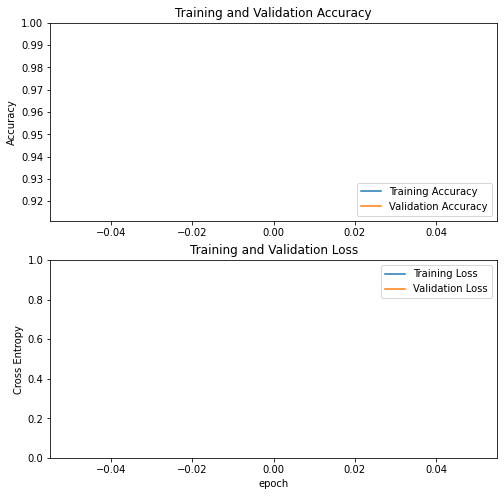

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
INITIAL_MODEL.trainable = True

In [36]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in INITIAL_MODEL.layers[:fine_tune_at]:
  layer.trainable =  False

In [37]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits= False), optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate/10),
              metrics=['accuracy','Precision','Recall'])

In [38]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1281      
Total params: 4,050,852
Trainable params: 3,841,629
Non-trainable params: 209,223
_____________________________________________

In [39]:
fine_tune_epochs = 1
total_epochs =  epochs + fine_tune_epochs

history_fine = model.fit(TRAIN_IT,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=VAL_IT)

Epoch 1/2
1053/1053 [==============================] - 124s 109ms/step - loss: 0.0902 - accuracy: 0.9619 - precision: 0.9798 - recall: 0.9529 - val_loss: 0.0509 - val_accuracy: 0.9790 - val_precision: 0.9891 - val_recall: 0.9773
Epoch 2/2
1053/1053 [==============================] - 112s 106ms/step - loss: 0.0614 - accuracy: 0.9747 - precision: 0.9849 - recall: 0.9705 - val_loss: 0.0477 - val_accuracy: 0.9801 - val_precision: 0.9932 - val_recall: 0.9749


In [40]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

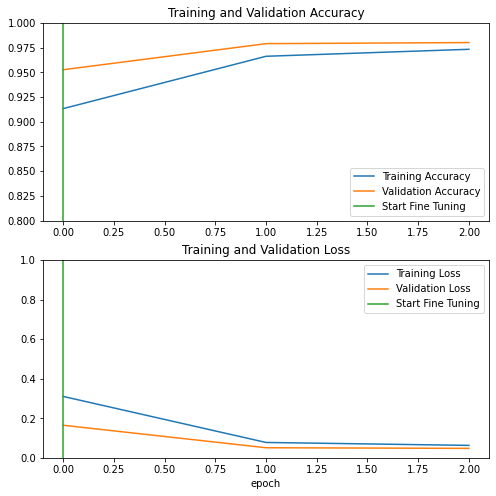

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [42]:
loss, accuracy, precision, recall = model.evaluate(TEST_IT)
print('Test accuracy :', accuracy)
print('Test precision :', precision)
print('Test recall :', recall)

397/397 [==============================] - 29s 72ms/step - loss: 0.0461 - accuracy: 0.9813 - precision: 0.9941 - recall: 0.9759
Test accuracy : 0.9813327193260193
Test precision : 0.9940881729125977
Test recall : 0.9759020805358887


In [43]:
f1_score = (2*precision*recall)/(precision+recall)
print('F1 Score : ', f1_score)

F1 Score :  0.9849111836805262


Predictions:
 [0 1 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1]
Labels:
 [0 1 1 1 0 0 0 0 1 1 1 0 0 1 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1]


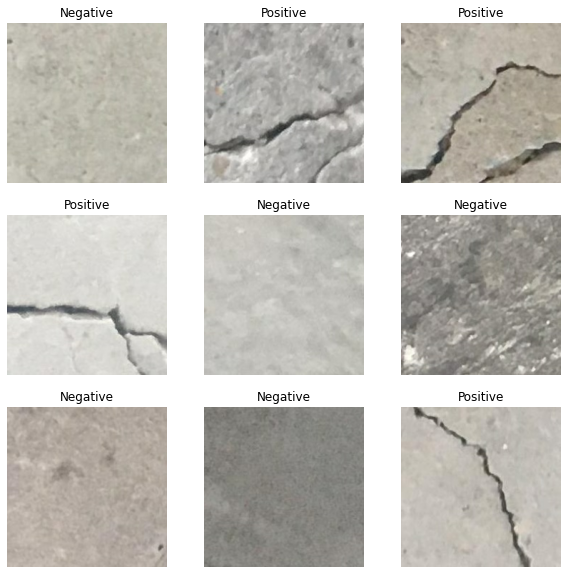

In [44]:
#Retrieve a batch of images from the test set
image_batch, label_batch = TEST_IT.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
class_names = ['Negative', 'Positive']
# Apply a sigmoid since our model returns logits
#predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [45]:
#model.save_weights("efficientnet_concrete_crack_detection")